<a href="https://colab.research.google.com/github/prcm066/cancer_detection_example/blob/main/Disaster_Tweets_Roberta_5fold_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Disaster Tweets


## 1. Introduction

We are tackling the problem of classifying tweets as either disaster-related or non-disaster-related, as part of the "Natural Language Processing with Disaster Tweets" competition. The goal is to build an ML model capable of identifying tweets that announce real emergencies.
As part of the assignment of week 4, and keeping with the theme of the lectures,  i proposed a Bi-directional Long Short-term memory architecture to tackle this task, however, it was clear that we hit a plateau at around ~0.78 accuracy and I didn't like the middle of the pack ranking.

### 1.2. Proposed Improvements

* **Transfer Learning**  For this final project I'll fine tune a Roberta Model with a binary classification head, leveraging a pretrained encoder only model. I selected to fine tune a [roberta-large](https://huggingface.co/FacebookAI/roberta-large) as I am familiar with its use and performance from my experience in the industry.

* **Data Augmentation** To ensure that the model is robust, I introduce a richer set of data augmentation steps for training for example, random swap, random deletion, back translation and so on.

* **Ensemble Learning** I'll use Cross-Validation to train 5 models, and then perform majority vote for the final prediction. By training each one in a random sample of the training I reduce the risk of overfitting and will allow better generalization.


### 1.3. Results

The combination of this efforts allowed me to climb to **Rank 23** in the leaderboard.

![image.png](attachment:6b3c363c-ed05-45f6-afa0-b3d48d934b7b.png)

A great imrovement over the previous one at **Rank 455** when i used bidirectional LSTM with limited data augmentation
![Captura de pantalla 2025-03-01 144013.png](attachment:b9712f97-e0ba-4d1c-97df-5fbd9b46ff94.png)

## 2. Setup

In this section we are preparing the environment, installing dependencies and importing libraries.
We are relying heavily on Torch and the transformers library from HuggingFace.
The model was fitted using Google Colab with TPU instances (A100 high RAM), I gave up trying to use the TPU

In [ ]:
!pip install transformers datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00


In [ ]:
!pip install nlpaug -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 25.3 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from datasets import Dataset
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
from tqdm.auto import tqdm

# === 1. TPU Setup ===
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', resolver.master())

  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)

except ValueError:
  print("No TPU detected. Using GPU or CPU.")
  strategy = tf.distribute.get_strategy()

print("Number of replicas:", strategy.num_replicas_in_sync)

No TPU detected. Using GPU or CPU.
Number of replicas: 1


The final run was done using GPU. Setting up the TPU's was problematic and time consuming and a fast and powerful GPU like an A100 is cheap: for 10 dollars i got approximately 12 hours of A100 compute. The training took less than an hour for 5 fine tuned models.

Below I mount and extract the files from my GoogleDrive. The memory in the colab notebook is volatile, so i have to run this step whenever we are starting the runtime.

In [ ]:
#  ********* Mounting the Drive and unzlipping the files
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/My Drive/nlp-getting-started.zip" /content/
!unzip nlp-getting-started.zip

Mounted at /content/drive
Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## 3 Exploratory Data Analysis.

Same as in week 4. We notice that the classes are slightly imbalanced and that the length of the tweets has a mode at 140 for both classes Dissaster and Not-Dissaster, however the Dissaster class has a heavier concentration in the 140 character mark.


Training data shape: (7613, 5)
Test data shape: (3263, 4)


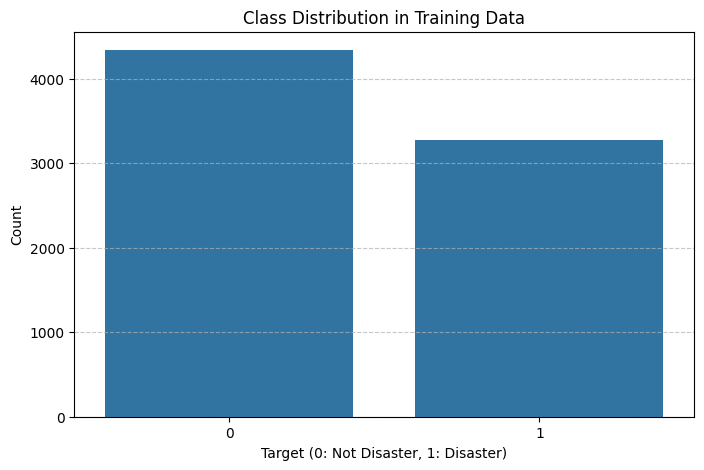

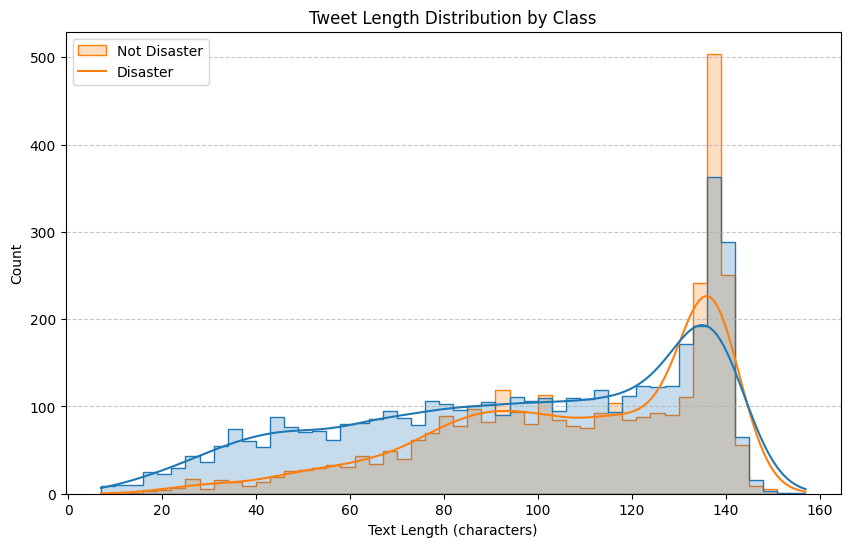

In [ ]:


# ******** Data Loading and Quick & Dirty EDA *******
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=train_df)
plt.title('Class Distribution in Training Data')
plt.xlabel('Target (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Analyze tweet length distribution
train_df['text_length'] = train_df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='text_length', hue='target', bins=50, kde=True, element="step")
plt.title('Tweet Length Distribution by Class')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Not Disaster', 'Disaster'])
plt.show()


## Data Augmentation

By inspecting the tweets you can notice that the language is not clean. It has embedded URL's, it includes emojis, has typos, seems written by users whose first language is not English, or that used a translator. The data augmenation objectives is twofold.

* **Balance the sample** We only augment in order to balance the sample by oversampling the minority class (Disaster)
* **Ensure Robustness** We make perturbations to the sample as shown below to get syntetic new samples that will allow the model to be robust to this kind of noise.


In [ ]:

# ******** Data Augmentation Functions ********
def synonym_replacement(text, n=1):
    """Replace n words with synonyms"""
    aug = naw.SynonymAug(aug_src='wordnet')
    try:
        augmented_text = aug.augment(text, n=n)
        return augmented_text
    except:
        return text

def random_swap(text, n=1):
    """Randomly swap n words in the text"""
    aug = naw.RandomWordAug(action="swap")
    try:
        augmented_text = aug.augment(text)
        return augmented_text
    except:
        return text

def random_deletion(text, p=0.1):
    """Randomly delete words with probability p"""
    aug = naw.RandomWordAug(action="delete", aug_p=p)
    try:
        augmented_text = aug.augment(text)
        return augmented_text
    except:
        return text

def back_translation(text, src_lang='en', target_lang='fr'):
    """Translate text to another language and back to English"""
    aug = naw.BackTranslationAug(
        from_model_name='facebook/wmt19-en-de',
        to_model_name='facebook/wmt19-de-en'
    )
    try:
        augmented_text = aug.augment(text)
        return augmented_text
    except:
        return text

def keyboard_aug(text):
    """Simulate keyboard typing errors"""
    aug = nac.KeyboardAug()
    try:
        augmented_text = aug.augment(text)
        return augmented_text
    except:
        return text

# Apply augmentation to disaster tweets (class 1) to balance the dataset
disaster_tweets = train_df[train_df['target'] == 1].copy()
non_disaster_tweets = train_df[train_df['target'] == 0].copy()

augmented_tweets = []
augmented_labels = []

# Only augment if there's class imbalance
if len(disaster_tweets) < len(non_disaster_tweets):
    # Calculate how many samples we need to generate
    n_to_generate = len(non_disaster_tweets) - len(disaster_tweets)

    # Apply different augmentation techniques
    for i, row in tqdm(disaster_tweets.iterrows(), total=min(len(disaster_tweets), n_to_generate),
                       desc="Augmenting disaster tweets"):
        if len(augmented_tweets) >= n_to_generate:
            break

        text = row['text']
        # Apply a randomly chosen augmentation technique
        aug_technique = random.choice([
            synonym_replacement,
            random_swap,
            random_deletion,
            keyboard_aug
        ])

        augmented_text = aug_technique(text)
        augmented_tweets.append(augmented_text)
        augmented_labels.append(1)  # disaster class

    # Create DataFrame for augmented samples
    aug_df = pd.DataFrame({
        'id': range(len(train_df), len(train_df) + len(augmented_tweets)),
        'text': augmented_tweets,
        'target': augmented_labels
    })

    # Concatenate with original data
    train_df = pd.concat([train_df, aug_df], ignore_index=True)
    print(f"Added {len(augmented_tweets)} augmented samples. New training data shape: {train_df.shape}")


Augmenting disaster tweets:   0%|          | 0/1071 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is al

Added 1071 augmented samples. New training data shape: (8684, 6)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger t

## 4 Cross Validation

We use 5-fold cross-validation, 3 epochs for each CV sample. Each of the five CV models are used in an ensemble to get the final prediction.
The Cross-Validation Accuracy was fairly close to the actual Accuracy from Kaggle evaluation.




In [ ]:

# ******* Cross-Validation Setup *********
# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

# Function to tokenize text data
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Prepare the test dataset
test_dataset = Dataset.from_dict({"text": test_df['text'].tolist()})  # Convert to list
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type='tensorflow', columns=['input_ids', 'attention_mask'])

# Create TF dataset for test data
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
AUTOTUNE = tf.data.AUTOTUNE

def create_tf_dataset(dataset, shuffle=True):
    tf_dataset = tf.data.Dataset.from_tensor_slices({
        'input_ids': dataset['input_ids'],
        'attention_mask': dataset['attention_mask'],
        'labels': dataset['labels'] if 'labels' in dataset.features else tf.zeros(len(dataset), dtype=tf.int32)
    })

    if shuffle:
        tf_dataset = tf_dataset.shuffle(buffer_size=len(dataset))

    tf_dataset = tf_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return tf_dataset

test_tf_dataset = create_tf_dataset(test_dataset, shuffle=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]


--- Training Fold 1/5 ---


Map:   0%|          | 0/6947 [00:00<?, ? examples/s]

Map:   0%|          | 0/1737 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/3
435/435 [==============================] - 179s 212ms/step - loss: 0.4382 - accuracy: 0.8029 - val_loss: 0.3624 - val_accuracy: 0.8486 - lr: 2.0000e-05
Epoch 2/3
435/435 [==============================] - 76s 174ms/step - loss: 0.3414 - accuracy: 0.8586 - val_loss: 0.3639 - val_accuracy: 0.8520 - lr: 2.0000e-05
Epoch 3/3
109/109 [==============================] - 7s 64ms/step - loss: 0.3691 - accuracy: 0.8561
Fold 1 Validation Accuracy: 0.8561
204/204 [==============================] - 19s 63ms/step

--- Training Fold 2/5 ---


Map:   0%|          | 0/6947 [00:00<?, ? examples/s]

Map:   0%|          | 0/1737 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/3
435/435 [==============================] - 173s 214ms/step - loss: 0.4382 - accuracy: 0.7980 - val_loss: 0.3715 - val_accuracy: 0.8371 - lr: 2.0000e-05
Epoch 2/3
435/435 [==============================] - 76s 174ms/step - loss: 0.3353 - accuracy: 0.8620 - val_loss: 0.3508 - val_accuracy: 0.8578 - lr: 2.0000e-05
Epoch 3/3
109/109 [==============================] - 7s 64ms/step - loss: 0.3508 - accuracy: 0.8578
Fold 2 Validation Accuracy: 0.8578
204/204 [==============================] - 22s 64ms/step

--- Training Fold 3/5 ---


Map:   0%|          | 0/6947 [00:00<?, ? examples/s]

Map:   0%|          | 0/1737 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/3
435/435 [==============================] - 175s 214ms/step - loss: 0.4401 - accuracy: 0.8038 - val_loss: 0.3846 - val_accuracy: 0.8451 - lr: 2.0000e-05
Epoch 2/3
435/435 [==============================] - 76s 175ms/step - loss: 0.3435 - accuracy: 0.8586 - val_loss: 0.3671 - val_accuracy: 0.8509 - lr: 2.0000e-05
Epoch 3/3
109/109 [==============================] - 7s 65ms/step - loss: 0.3671 - accuracy: 0.8509
Fold 3 Validation Accuracy: 0.8509
204/204 [==============================] - 19s 65ms/step

--- Training Fold 4/5 ---


Map:   0%|          | 0/6947 [00:00<?, ? examples/s]

Map:   0%|          | 0/1737 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/3
435/435 [==============================] - 176s 215ms/step - loss: 0.6239 - accuracy: 0.6337 - val_loss: 0.4475 - val_accuracy: 0.7847 - lr: 2.0000e-05
Epoch 2/3
435/435 [==============================] - 76s 174ms/step - loss: 0.4020 - accuracy: 0.8309 - val_loss: 0.3562 - val_accuracy: 0.8457 - lr: 2.0000e-05
Epoch 3/3
109/109 [==============================] - 7s 64ms/step - loss: 0.3562 - accuracy: 0.8457
Fold 4 Validation Accuracy: 0.8457
204/204 [==============================] - 20s 66ms/step

--- Training Fold 5/5 ---


Map:   0%|          | 0/6948 [00:00<?, ? examples/s]

Map:   0%|          | 0/1736 [00:00<?, ? examples/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/3
435/435 [==============================] - 180s 220ms/step - loss: 0.4273 - accuracy: 0.8140 - val_loss: 0.3932 - val_accuracy: 0.8306 - lr: 2.0000e-05
Epoch 2/3
435/435 [==============================] - 77s 176ms/step - loss: 0.3326 - accuracy: 0.8676 - val_loss: 0.5496 - val_accuracy: 0.8030 - lr: 2.0000e-05
Epoch 3/3
109/109 [==============================] - 7s 67ms/step - loss: 0.4227 - accuracy: 0.8335
Fold 5 Validation Accuracy: 0.8335
204/204 [==============================] - 20s 66ms/step


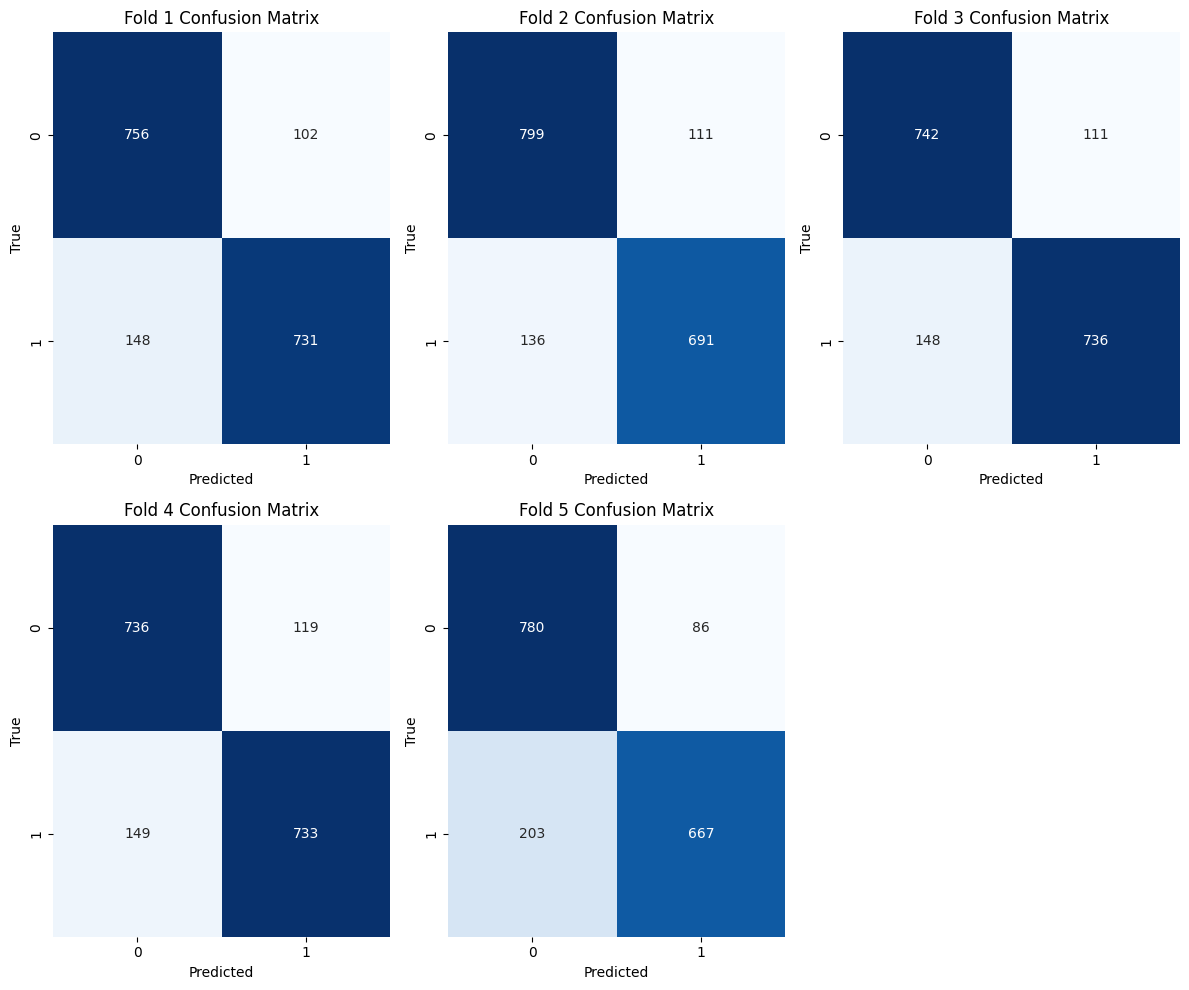

In [ ]:

# ******* Cross-Validation Training *******
# Number of folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store fold results
fold_predictions = []
fold_accuracies = []
fold_losses = []
fold_val_predictions = []
fold_val_true_labels = []
fold_histories = []

# Visualization setup for cross-validation
plt.figure(figsize=(12, 10))

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f"\n--- Training Fold {fold+1}/{k_folds} ---")

    # Split the data for this fold
    fold_train_df = train_df.iloc[train_idx]
    fold_val_df = train_df.iloc[val_idx]

    # Prepare datasets - convert numpy arrays to lists to avoid arrow type issues
    fold_train_dataset = Dataset.from_dict({
        "text": fold_train_df['text'].astype(str).tolist(),
        "labels": fold_train_df['target'].tolist()
    })

    fold_val_dataset = Dataset.from_dict({
        "text": fold_val_df['text'].astype(str).tolist(),
        "labels": fold_val_df['target'].tolist()
    })

    # Tokenize
    fold_train_dataset = fold_train_dataset.map(tokenize_function, batched=True)
    fold_val_dataset = fold_val_dataset.map(tokenize_function, batched=True)

    # Set format for TensorFlow
    fold_train_dataset.set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'labels'])
    fold_val_dataset.set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'labels'])

    # Create TF datasets
    fold_train_tf_dataset = create_tf_dataset(fold_train_dataset)
    fold_val_tf_dataset = create_tf_dataset(fold_val_dataset, shuffle=False)

    # Train the model for this fold
    with strategy.scope():
        # Load the model
        model = TFRobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=2)

        # Compile the model
        optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

        model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
    ]

    # Train the model
    history = model.fit(
        fold_train_tf_dataset,
        validation_data=fold_val_tf_dataset,
        epochs=3,
        callbacks=callbacks
    )

    # Store training history for plotting
    fold_histories.append(history.history)

    # Evaluate on validation set
    val_results = model.evaluate(fold_val_tf_dataset)
    fold_accuracies.append(val_results[1])  # Store accuracy
    fold_losses.append(val_results[0])  # Store loss
    print(f"Fold {fold+1} Validation Accuracy: {val_results[1]:.4f}")

    # Get validation predictions for metrics
    val_preds = model.predict(fold_val_tf_dataset)
    val_pred_labels = tf.argmax(val_preds.logits, axis=1).numpy()
    fold_val_predictions.append(val_pred_labels)
    fold_val_true_labels.append(fold_val_df['target'].values)

    # Make predictions on test set
    fold_preds = model.predict(test_tf_dataset)
    fold_pred_labels = tf.argmax(fold_preds.logits, axis=1).numpy()
    fold_predictions.append(fold_pred_labels)

    # Save the model for this fold (optional)
    model.save_weights(f'/content/roberta_disaster_fold_{fold+1}.h5')

    # Plot confusion matrix for this fold
    plt.subplot(2, 3, fold+1)
    cm = confusion_matrix(fold_val_df['target'].values, val_pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Fold {fold+1} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

# Finalize the confusion matrix subplot
plt.subplot(2, 3, k_folds+1)
plt.axis('off')
plt.tight_layout()
plt.show()


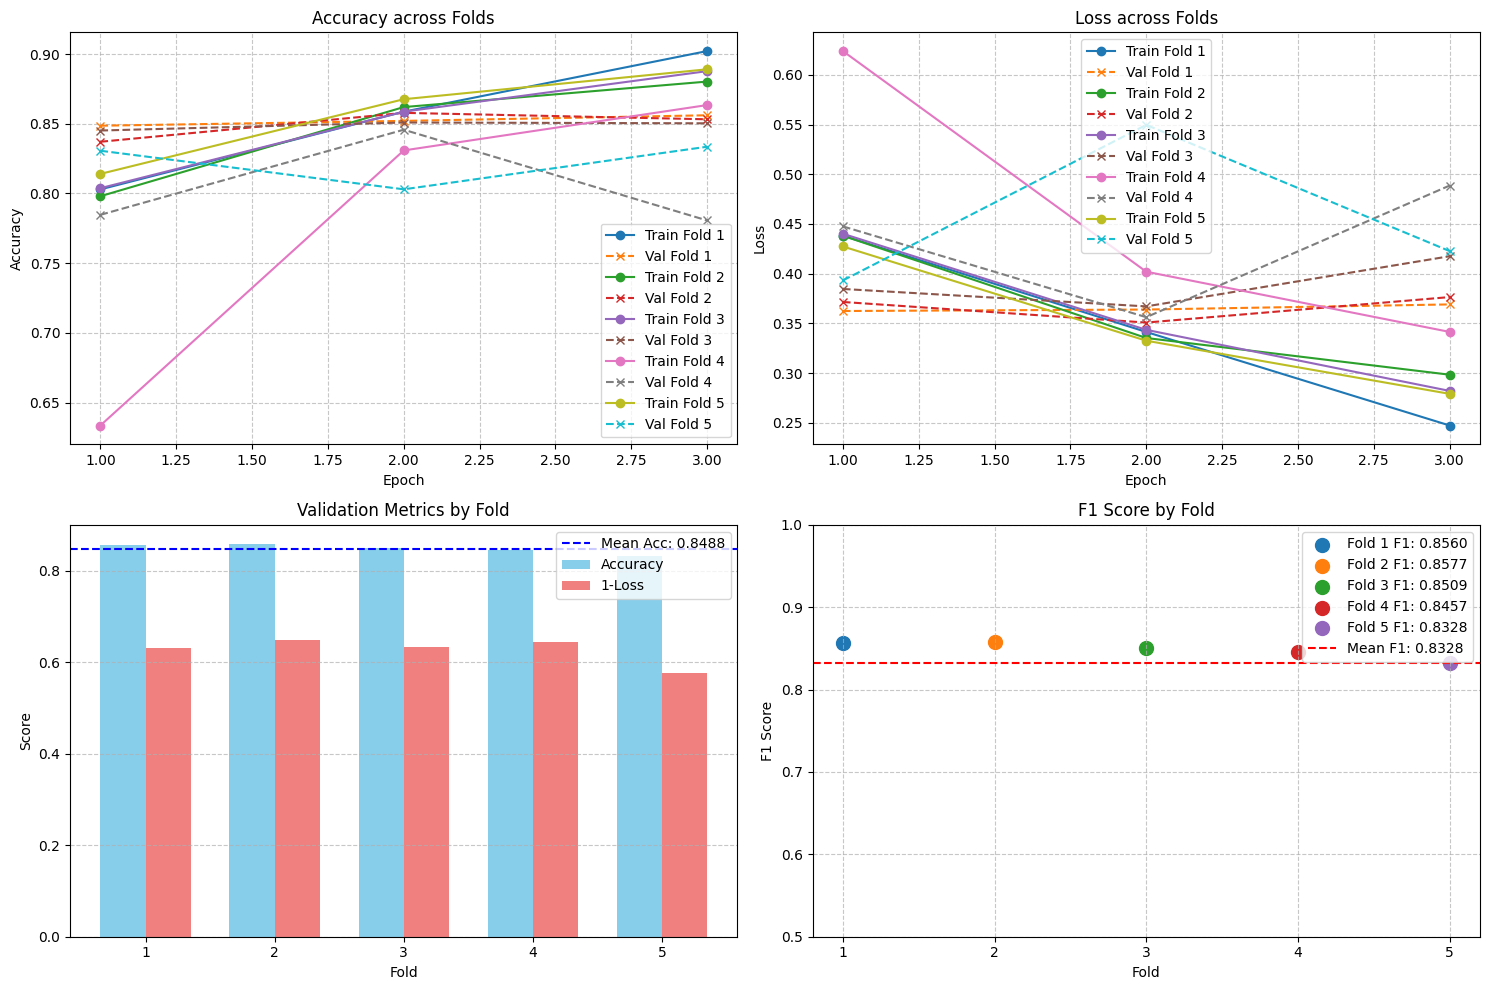

In [ ]:

# ****** Cross-Validation Results & Viz ***********
# Plot training and validation accuracy/loss across folds
plt.figure(figsize=(15, 10))

# Accuracy
plt.subplot(2, 2, 1)
for fold, history in enumerate(fold_histories):
    plt.plot([i+1 for i in range(len(history['accuracy']))], history['accuracy'],
             marker='o', label=f'Train Fold {fold+1}')
    plt.plot([i+1 for i in range(len(history['val_accuracy']))], history['val_accuracy'],
             marker='x', linestyle='--', label=f'Val Fold {fold+1}')
plt.title('Accuracy across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Loss
plt.subplot(2, 2, 2)
for fold, history in enumerate(fold_histories):
    plt.plot([i+1 for i in range(len(history['loss']))], history['loss'],
             marker='o', label=f'Train Fold {fold+1}')
    plt.plot([i+1 for i in range(len(history['val_loss']))], history['val_loss'],
             marker='x', linestyle='--', label=f'Val Fold {fold+1}')
plt.title('Loss across Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Validation Metrics Summary
plt.subplot(2, 2, 3)
bar_width = 0.35
index = range(1, k_folds + 1)
plt.bar([i - bar_width/2 for i in index], fold_accuracies, bar_width, label='Accuracy', color='skyblue')
plt.bar([i + bar_width/2 for i in index], [1-loss for loss in fold_losses], bar_width, label='1-Loss', color='lightcoral')
plt.axhline(y=np.mean(fold_accuracies), color='blue', linestyle='--', label=f'Mean Acc: {np.mean(fold_accuracies):.4f}')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Validation Metrics by Fold')
plt.xticks(index)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# ROC Curves
plt.subplot(2, 2, 4)
for fold in range(k_folds):
    # Combine and flatten predictions/labels for each fold
    y_true = fold_val_true_labels[fold]
    y_pred = fold_val_predictions[fold]

    # Calculate classification metrics
    report = classification_report(y_true, y_pred, output_dict=True)
    f1 = report['weighted avg']['f1-score']

    # Draw ROC curve
    plt.scatter([fold+1], [f1], s=100, label=f'Fold {fold+1} F1: {f1:.4f}')

plt.axhline(y=np.mean([report['weighted avg']['f1-score'] for fold in range(k_folds)]),
            color='red', linestyle='--',
            label=f'Mean F1: {np.mean([report["weighted avg"]["f1-score"] for fold in range(k_folds)]):.4f}')
plt.title('F1 Score by Fold')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.ylim(0.5, 1.0)
plt.xticks(range(1, k_folds+1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


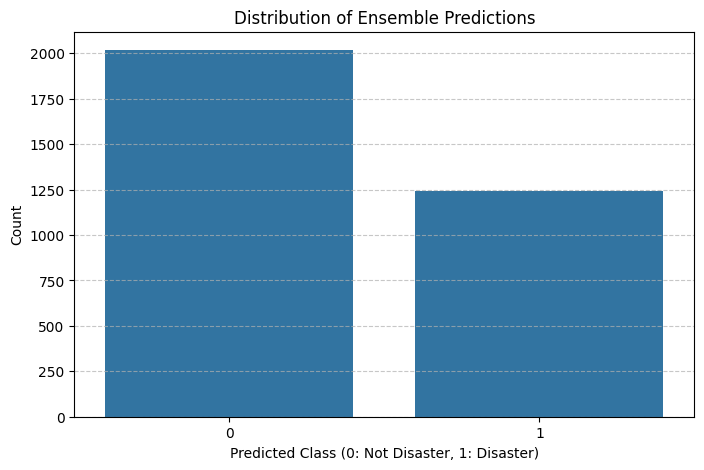


Submission file created!

Cross-Validation Results:
Fold 1 Accuracy: 0.8561, Loss: 0.3691
Fold 2 Accuracy: 0.8578, Loss: 0.3508
Fold 3 Accuracy: 0.8509, Loss: 0.3671
Fold 4 Accuracy: 0.8457, Loss: 0.3562
Fold 5 Accuracy: 0.8335, Loss: 0.4227
Average CV Accuracy: 0.8488 ± 0.0087


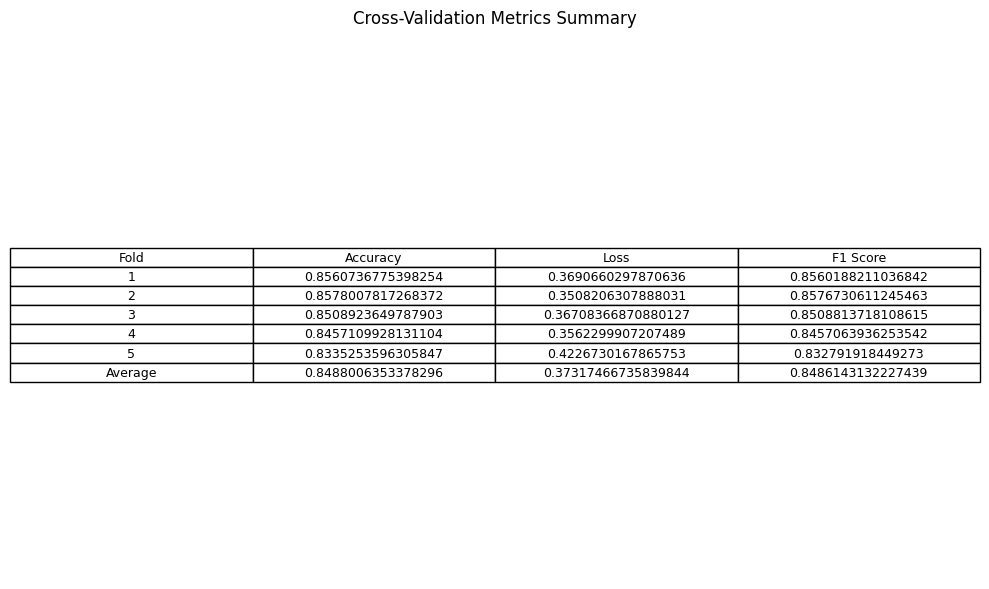

In [ ]:

# ********* Ensemble Predictior & Majority Vote ***********
# Convert predictions to numpy array for easier manipulation
fold_predictions = np.array(fold_predictions)

# Use majority voting for final predictions
final_predictions = np.apply_along_axis(
    lambda x: np.bincount(x).argmax(),
    axis=0,
    arr=fold_predictions
)

# Visualize ensemble predictions distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=final_predictions)
plt.title('Distribution of Ensemble Predictions')
plt.xlabel('Predicted Class (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Create submission file
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': final_predictions
})

submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file created!")

# Print cross-validation summary
print(f"\nCross-Validation Results:")
for fold, acc in enumerate(fold_accuracies):
    print(f"Fold {fold+1} Accuracy: {acc:.4f}, Loss: {fold_losses[fold]:.4f}")
print(f"Average CV Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")

# Plot per-fold metrics in a nice summary table
plt.figure(figsize=(10, 6))
metrics_table = pd.DataFrame({
    'Fold': range(1, k_folds + 1),
    'Accuracy': fold_accuracies,
    'Loss': fold_losses,
    'F1 Score': [classification_report(fold_val_true_labels[i], fold_val_predictions[i], output_dict=True)['weighted avg']['f1-score']
                for i in range(len(fold_val_true_labels))]
})

# Add a row for averages
metrics_table.loc[k_folds] = ['Average',
                             np.mean(fold_accuracies),
                             np.mean(fold_losses),
                             np.mean([classification_report(fold_val_true_labels[i], fold_val_predictions[i], output_dict=True)['weighted avg']['f1-score']
                                    for i in range(len(fold_val_true_labels))])]

# Plot as a table
plt.axis('off')
plt.table(cellText=metrics_table.values,
          colLabels=metrics_table.columns,
          loc='center',
          cellLoc='center')
plt.title('Cross-Validation Metrics Summary', pad=20)
plt.tight_layout()
plt.show()
